In [4]:
%matplotlib inline 

import Levenshtein as Lev

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from collections import Counter

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score

import utils
import importlib
importlib.reload(utils)
from utils import *

oh_dict = load_dict()

In [5]:
df_pos = load_dataset("data/GSM3155092_P01_CRVstim_CD8_beta.txt.gz")
df_neg = load_dataset("data/GSM3155090_P01_unstim_CD8_beta.txt.gz")

df_neg = filter_specific(df_pos, df_neg)

print(len(df_pos))
print(len(df_neg))

 - Dropped 3106 duplicates
 - Dropped 62656 duplicates
 - Removed 15566 sequences
80214
495796


In [6]:
df_pos = df_pos.loc[df_pos["Read.count"] != 1, :].reset_index(drop=True)
df_neg = df_neg.loc[df_neg["Read.count"] > 2, :].reset_index(drop=True)

print(len(df_pos))
print(len(df_neg))

41446
359824


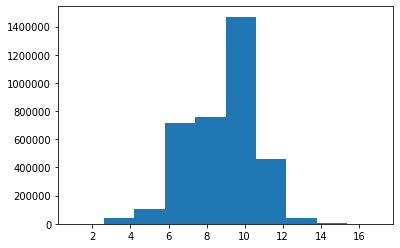

In [7]:
def seq_distance(sources, targets):
    dist_list = []
    for s in sources:
        for t in targets:
            dist_list.append(Lev.distance(s, t))
    return dist_list

distr = seq_distance(list(df_pos["CDR3.sequence"][0:10]), list(df_neg["CDR3.sequence"]))

_ = plt.hist(distr)

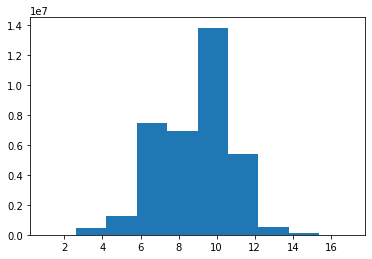

In [18]:
from multiprocessing import Pool
import itertools

def seq_distance2(args):
    return [Lev.distance(args[0], t) for t in args[1]]

targets = list(df_neg["CDR3.sequence"])
i = 100
with Pool(processes=2) as pool:
    res = pool.map(seq_distance2, zip(list(df_pos["CDR3.sequence"][0:i]), [targets for i in range(i)]))
    res = list(itertools.chain.from_iterable(res))
    
_ = plt.hist(res)

Counter({9: 1946102, 8: 1715692, 10: 1620138, 7: 1148524, 11: 986210, 6: 613286, 12: 430886, 5: 268092, 13: 133296, 4: 84262, 14: 28556, 3: 15874, 15: 4072, 0: 3000, 2: 1692, 16: 230, 1: 84, 17: 4})


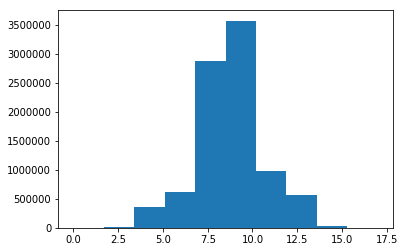

In [18]:
indices = np.random.choice(len(df_neg), 3000, replace=False)
df_neg_tmp = df_neg.iloc[indices, :]

distr = seq_distance(list(df_neg_tmp["CDR3.sequence"]), list(df_neg_tmp["CDR3.sequence"]))
_ = plt.hist(distr)
print(Counter(distr))

In [20]:
test_size = 5000

indices = np.random.choice(len(df_pos), test_size, replace=False)
df_pos_test = df_pos.iloc[indices, :]
df_pos_train = df_pos.drop(indices)

print(len(df_pos_test))
print(len(df_pos_train))

indices = np.random.choice(len(df_neg), test_size, replace=False)
df_neg_test = df_neg.iloc[indices, :]
df_neg_train = df_neg.drop(indices)

print(len(df_neg_test))
print(len(df_neg_train))

5000
36446
5000
354824


Text(0.5, 1.0, 'test- train+')

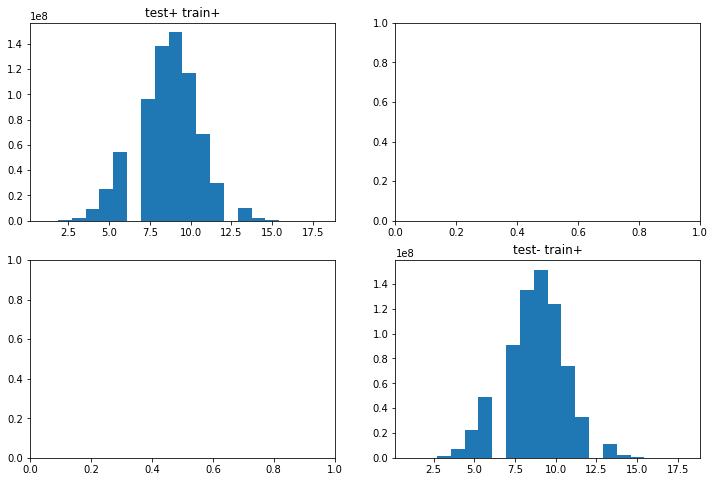

In [5]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)

distr = []
distr.append(seq_distance(df_pos_test["CDR3.sequence"], df_pos_train["CDR3.sequence"]))
ax[0][0].hist(distr[-1], bins=20)
ax[0][0].set_title("test+ train+")

# ax[0][1].hist(seq_distance(df_neg_test["CDR3.sequence"], df_neg_train["CDR3.sequence"]), bins=20)
# ax[0][1].set_title("test- train-")

# ax[1][0].hist(seq_distance(df_pos_test["CDR3.sequence"], df_neg_train["CDR3.sequence"]), bins=20)
# ax[1][0].set_title("test+ train-")

distr.append(seq_distance(df_neg_test["CDR3.sequence"], df_pos_train["CDR3.sequence"]))
ax[1][1].hist(distr[-1], bins=20)
ax[1][1].set_title("test- train+")

In [6]:
tmp = np.array(distr[0])
tmp = tmp[tmp < 4]
Counter(tmp)

Counter({3: 2044912, 2: 260763, 1: 16110})

(array([1.61100000e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.60763000e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.04491200e+06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.88429100e+06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50926060e+07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.40535860e+07, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.65348460e+07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.38348647e+08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.49193867e+08,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.17154720e+08, 0.00000000e+00, 0.00000000e+00, 0.000000

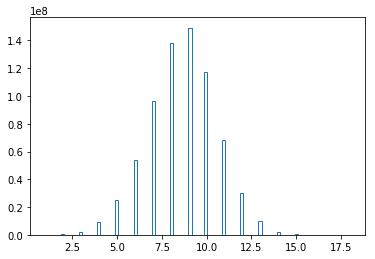

In [13]:
plt.hist(distr[0], bins=100, histtype="step")

In [7]:
tmp = np.array(distr[1])
tmp = tmp[tmp < 4]
Counter(tmp)

Counter({3: 1473806, 1: 7824, 2: 157321})

(array([7.82400000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.57321000e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.47380600e+06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.31151200e+06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.21524020e+07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.92492470e+07, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.06250400e+07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.34859361e+08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.51638407e+08,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.23706503e+08, 0.00000000e+00, 0.00000000e+00, 0.000000

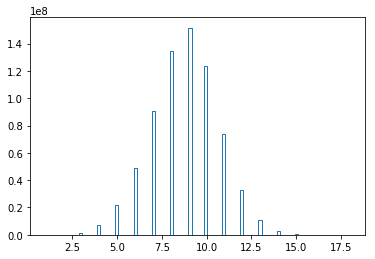

In [14]:
plt.hist(distr[-1], bins=100, histtype="step")